# 311 Noise Data Collection 

**cowork by Pingzi Li and Xurui Chen**

[1. Data Collection](#Data_Collection)

[2. Data Cleaning](#Data_Cleaning)

[3. Data Exploring](#Data_Exploring)

**Data sources**

We will use the noise part of 311 service data. 

Also, could we get the noise data measuring around the rezoning area?

**Analysis approaches**

1. no-action situation 

a. Analyze the noise complaint through the past 5 or 10 years and figure out the trend through the years (time series). 

b. Compare the past 5 or 10 years noise complaint in day and night.

2. with-action situation

a. Select the cases which have similar situation after rezoning and analyze the noise change after rezoning and the different of noise complaint number/type between the case area and its around area. (try difference-in-difference approach)

b. Select factors which affect the noise after rezoning from similar cases and predict future noise based on the measured data.

## Data_Collection

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import os
import geopandas as gpd
from sodapy import Socrata
import urllib
import requests
import string
from IPython.display import Image
# from .query_integral_image import query_integral_image
from wordcloud import WordCloud
import shapely
from fiona.crs import from_epsg

pd.set_option('display.max_columns', 500)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

In [3]:
def get311data(key, start_time, end_time):
    client = Socrata("data.cityofnewyork.us", key)
    results = client.get("fhrw-4uyv", where = "created_date BETWEEN " + start_time + " AND " +  end_time, limit = 1000000000)
    
    return(pd.DataFrame.from_records(results))

In [4]:
data311 = get311data('jjCh6OTqr3VrUwNTNl4bPGwAK',  "'2018-07-01T00:00:00'", "'2018-07-31T00:00:00'")

In [5]:
data311.head()

address_type agency                              agency_name         bbl  \
0      ADDRESS  DOHMH  Department of Health and Mental Hygiene  1009090034   
1      ADDRESS  DOHMH  Department of Health and Mental Hygiene  3076760054   
2      ADDRESS   DSNY                 Department of Sanitation  1004470039   
3      ADDRESS  DOHMH  Department of Health and Mental Hygiene  3082720026   
4      ADDRESS  DOHMH  Department of Health and Mental Hygiene  5003740146   

         borough bridge_highway_direction bridge_highway_name  \
0      MANHATTAN                      NaN                 NaN   
1       BROOKLYN                      NaN                 NaN   
2      MANHATTAN                      NaN                 NaN   
3       BROOKLYN                      NaN                 NaN   
4  STATEN ISLAND                      NaN                 NaN   

  bridge_highway_segment           city              closed_date  \
0                    NaN       NEW YORK  2018-07-05T14:13:30.000   
1                    NaN       BROOKLYN                      NaN   
2                    NaN       NEW YORK  2018-07-03T00:00:00.000   
3                    NaN       BROOKLYN  2018-07-10T00:00:00.000   
4                    NaN  STATEN ISLAND  2018-07-01T00:00:00.000   

    community_board                       complaint_type  \
0      06 MANHATTAN                               Rodent   
1       14 BROOKLYN                               Rodent   
2      03 MANHATTAN  Request Large Bulky Item Collection   
3       18 BROOKLYN                       Standing Water   
4  01 STATEN ISLAND                               Rodent   

              created_date   cross_street_1   cross_street_2  \
0  2018-07-01T00:00:00.000   EAST 28 STREET   EAST 29 STREET   
1  2018-07-01T00:00:00.000       BAY AVENUE         AVENUE O   
2  2018-07-01T00:00:00.000         2 AVENUE         1 AVENUE   
3  2018-07-01T00:00:00.000  EAST 105 STREET  EAST 108 STREET   
4  2018-07-01T00:00:00.000    ELMIRA AVENUE  CONSTANT AVENUE   

                            descriptor                 due_date facility_type  \
0                       Mouse Sighting  2018-07-31T01:40:36.000           N/A   
1                         Rat Sighting  2018-07-31T01:47:58.000           N/A   
2  Request Large Bulky Item Collection                      NaN           N/A   
3         Swimming Pool - Unmaintained  2018-07-31T23:16:15.000           N/A   
4         Condition Attracting Rodents  2018-07-31T21:36:54.000           N/A   

              incident_address incident_zip intersection_street_1  \
0                 519 2 AVENUE        10016                   NaN   
1        1523 EAST   22 STREET        11210                   NaN   
2         339 EAST    5 STREET        10003                   NaN   
3  10554 FLATLANDS    6 STREET        11236                   NaN   
4        41 WESTCOTT BOULEVARD        10314                   NaN   

  intersection_street_2 landmark            latitude  \
0                   NaN      NaN   40.74155544671306   
1                   NaN      NaN    40.6145908510569   
2                   NaN      NaN  40.726364661118076   
3                   NaN      NaN   40.64226198000999   
4                   NaN      NaN  40.619533241068716   

                                            location            location_type  \
0  {'type': 'Point', 'coordinates': [-73.97824313...  3+ Family Apt. Building   
1  {'type': 'Point', 'coordinates': [-73.95227564...      1-2 Family Dwelling   
2  {'type': 'Point', 'coordinates': [-73.98797493...                 Sidewalk   
3  {'type': 'Point', 'coordinates': [-73.88685536...      1-2 Family Dwelling   
4  {'type': 'Point', 'coordinates': [-74.12801163...      1-2 Family Dwelling   

            longitude open_data_channel_type   park_borough  \
0  -73.97824313903494                 ONLINE      MANHATTAN   
1  -73.95227564865068                  PHONE       BROOKLYN   
2  -73.98797493992541                  PHONE      MANHATTAN   
3  -73.88

In [6]:
data311.columns

Index(['address_type', 'agency', 'agency_name', 'bbl', 'borough',
       'bridge_highway_direction', 'bridge_highway_name',
       'bridge_highway_segment', 'city', 'closed_date', 'community_board',
       'complaint_type', 'created_date', 'cross_street_1', 'cross_street_2',
       'descriptor', 'due_date', 'facility_type', 'incident_address',
       'incident_zip', 'intersection_street_1', 'intersection_street_2',
       'landmark', 'latitude', 'location', 'location_type', 'longitude',
       'open_data_channel_type', 'park_borough', 'park_facility_name',
       'resolution_action_updated_date', 'resolution_description', 'road_ramp',
       'status', 'street_name', 'taxi_company_borough',
       'taxi_pick_up_location', 'unique_key', 'vehicle_type',
       'x_coordinate_state_plane', 'y_coordinate_state_plane'],
      dtype='object')

In [7]:
data311.shape

(227494, 41)

In [8]:
data311.borough.unique()

array(['MANHATTAN', 'BROOKLYN', 'STATEN ISLAND', 'QUEENS', 'BRONX',
       'Unspecified'], dtype=object)

In [9]:
data311.complaint_type.unique()

array(['Rodent', 'Request Large Bulky Item Collection', 'Standing Water',
       'Food Poisoning', 'Unsanitary Animal Pvt Property',
       'HEAT/HOT WATER', 'Noise - Street/Sidewalk', 'Water System',
       'Noise - Residential', 'Noise - Commercial', 'Blocked Driveway',
       'Sewer', 'Illegal Parking', 'Noise - Vehicle', 'Street Condition',
       'ELECTRIC', 'Lead', 'Elevator', 'Street Light Condition',
       'Building/Use', 'Noise', 'For Hire Vehicle Complaint',
       'Traffic Signal Condition', 'Hazardous Materials',
       'UNSANITARY CONDITION', 'DOOR/WINDOW', 'Derelict Vehicle',
       'PLUMBING', 'Illegal Fireworks', 'Noise - Park', 'Water Quality',
       'Consumer Complaint', 'Animal Abuse', 'Dirty Conditions',
       'Taxi Complaint', 'Maintenance or Facility', 'Sidewalk Condition',
       'Electronics Waste', 'GENERAL', 'Derelict Vehicles',
       'FLOORING/STAIRS', 'PAINT/PLASTER', 'APPLIANCE',
       'Food Establishment', 'Noise - Helicopter',
       'Missed Collecti

## Data_Cleaning

In [10]:
def noiseSelect(data):
    if 'Noise' in data:
        return True
    else:
        return False

In [11]:
noise311 = data311[data311['complaint_type'].apply(noiseSelect)]
noise311.reset_index(drop = True, inplace = True)

In [12]:
noise311.head()

address_type agency                      agency_name         bbl   borough  \
0       ADDRESS   NYPD  New York City Police Department  2048200042     BRONX   
1       ADDRESS   NYPD  New York City Police Department  3014860043  BROOKLYN   
2  INTERSECTION   NYPD  New York City Police Department         NaN  BROOKLYN   
3       ADDRESS   NYPD  New York City Police Department  3039160113  BROOKLYN   
4       ADDRESS   NYPD  New York City Police Department  2028660110     BRONX   

  bridge_highway_direction bridge_highway_name bridge_highway_segment  \
0                      NaN                 NaN                    NaN   
1                      NaN                 NaN                    NaN   
2                      NaN                 NaN                    NaN   
3                      NaN                 NaN                    NaN   
4                      NaN                 NaN                    NaN   

       city              closed_date community_board           complaint_type  \
0     BRONX  2018-07-01T05:13:08.000        12 BRONX  Noise - Street/Sidewalk   
1  BROOKLYN  2018-07-01T08:03:37.000     03 BROOKLYN  Noise - Street/Sidewalk   
2  BROOKLYN  2018-07-01T02:38:03.000     05 BROOKLYN  Noise - Street/Sidewalk   
3  BROOKLYN  2018-07-01T02:01:06.000     05 BROOKLYN      Noise - Residential   
4     BRONX  2018-07-03T08:58:49.000        05 BRONX  Noise - Street/Sidewalk   

              created_date   cross_street_1       cross_street_2  \
0  2018-07-01T00:00:18.000  EAST 224 STREET      EAST 226 STREET   
1  2018-07-01T00:00:32.000    HOWARD AVENUE      SARATOGA AVENUE   
2  2018-07-01T00:01:01.000              NaN                  NaN   
3  2018-07-01T00:01:07.000      ETNA STREET     RIDGEWOOD AVENUE   
4  2018-07-01T00:01:07.000  WEST 176 STREET  WEST TREMONT AVENUE   

         descriptor                 due_date facility_type  \
0  Loud Music/Party  2018-07-01T08:00:18.000      Precinct   
1      Loud Talking  2018-07-01T08:00:32.000      Precinct   
2  Loud Music/Party  2018-07-01T08:01:01.000      Precinct   
3  Loud Music/Party  2018-07-01T08:01:07.000      Precinct   
4  Loud Music/Party  2018-07-01T08:01:07.000      Precinct   

       incident_address incident_zip intersection_street_1  \
0  3990 BRONX BOULEVARD        10466                   NaN   
1  997 JEFFERSON AVENUE        11221                   NaN   
2                   NaN        11207         JEROME STREET   
3     50 NORWOOD AVENUE        11208                   NaN   
4  1731 HARRISON AVENUE        10453                   NaN   

  intersection_street_2 landmark            latitude  \
0                   NaN      NaN   40.88934639713765   
1                   NaN      NaN   40.68686157441832   
2       GLENMORE AVENUE      NaN  40.674516113510094   
3                   NaN      NaN   40.68484572512785   
4                   NaN      NaN  40.849226341299804   

                                            location  \
0  {'type': 'Point', 'coordinates': [-73.86400388...   
1  {'type': 'Point', 'coordinates': [-73.91898258...   
2  {'type': 'Point', 'coordinates': [-73.88705300...   
3  {'type': 'Point', 'coordinates': [-73.87992879...   
4  {'type': 'Point', 'coordinates': [-73.91466424...   

                location_type           longitude open_data_channel_type  \
0             Street/Sidewalk  -73.86400388206638                 ONLINE   
1             Street/Sidewalk  -73.91898258455596                 MOBILE   
2             Street/Sidewalk  -73.88705300135015                  PHONE   
3  Residential Building/House  -73.87992879738181                 MOBILE   
4             Street/Sidewalk  -73.91466424683102                 MOBILE   

  park_borough park_facility_name resolution_action_updated_date  \
0        BRONX        Unspecified        2018-07-01T05:13:08.000   
1     BROOKLYN        Unspecified        2018-07-01T08:03:37.000   
2     BROOKLYN        Unspecified        2018-07-01T02:38:03.000   
3     BROOKLYN        Unspecifie

In [13]:
type(noise311.location[0])

dict

In [14]:
noise311.complaint_type.unique()

array(['Noise - Street/Sidewalk', 'Noise - Residential',
       'Noise - Commercial', 'Noise - Vehicle', 'Noise', 'Noise - Park',
       'Noise - Helicopter', 'Noise - House of Worship',
       'Collection Truck Noise'], dtype=object)

In [15]:
noise311.shape

(41469, 41)

In [16]:
def noiseType(data):
    if data.startswith('Noise'):
        data = data.replace('Noise - ', '')
        if '/' in data:
            return(data.replace('/', ' '))
        else:
            return(data)
    else:
        return(data.replace(' Noise', ''))

In [17]:
noiseType = noise311['complaint_type'].apply(noiseType).tolist()

In [18]:
type(noiseType)

list

In [19]:
noise311['noise_type'] = noiseType

/anaconda3/envs/myEnv3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Data_Exploring

In [20]:
manhattan = str(list(noise311[noise311["borough"]=="MANHATTAN"]['noise_type'].values))
brooklyn = str(list(noise311[noise311["borough"]=="BROOKLYN"]['noise_type'].values))
staten_island = str(list(noise311[noise311["borough"]=="STATEN ISLAND"]['noise_type'].values))
queens = str(list(noise311[noise311["borough"]=="QUEENS"]['noise_type'].values))
bronx = str(list(noise311[noise311["borough"]=="BRONX"]['noise_type'].values))
unspecified = str(list(noise311[noise311["borough"]=="Unspecified"]['noise_type'].values))

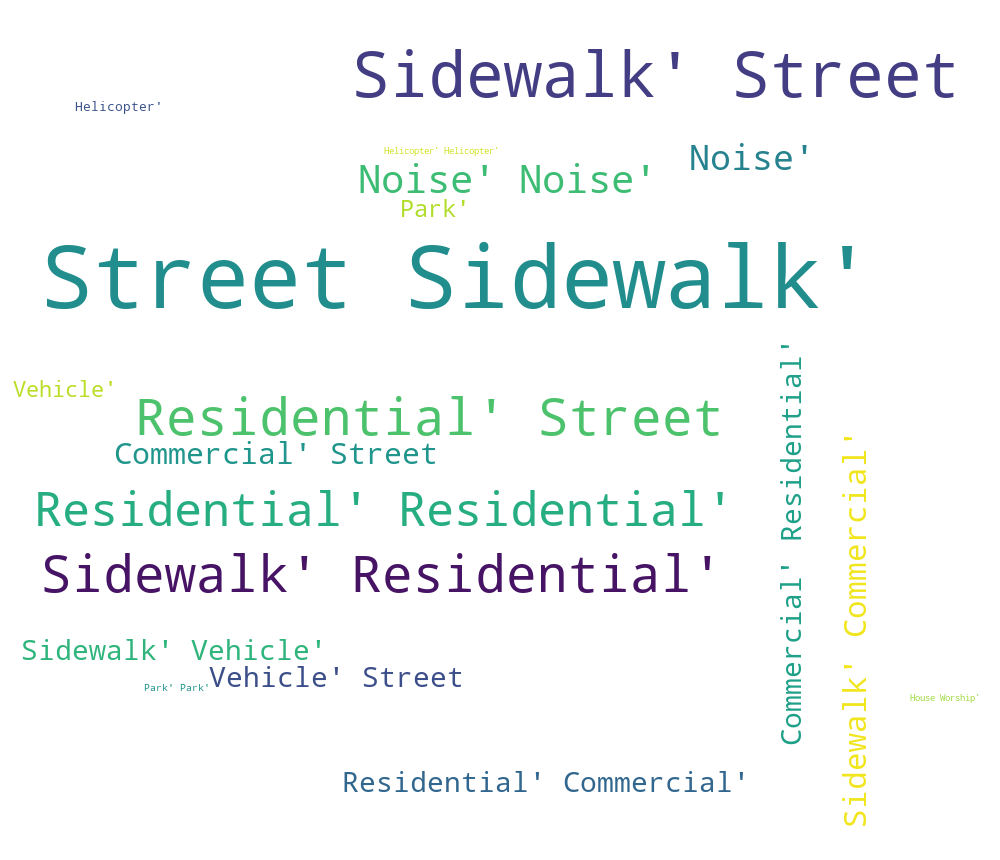

In [21]:
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(manhattan)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()
wordcloud.to_file('manhattan.png')
Image('manhattan.png')

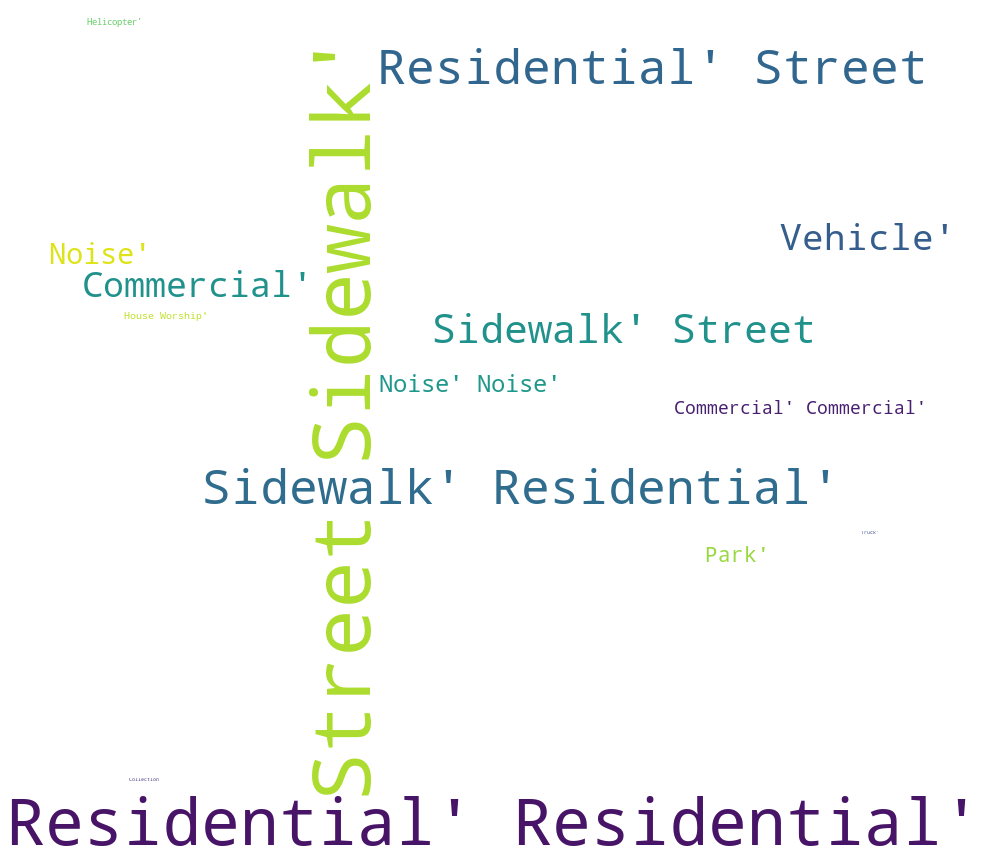

In [22]:
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(brooklyn)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()
wordcloud.to_file('brooklyn.png')
Image('brooklyn.png')

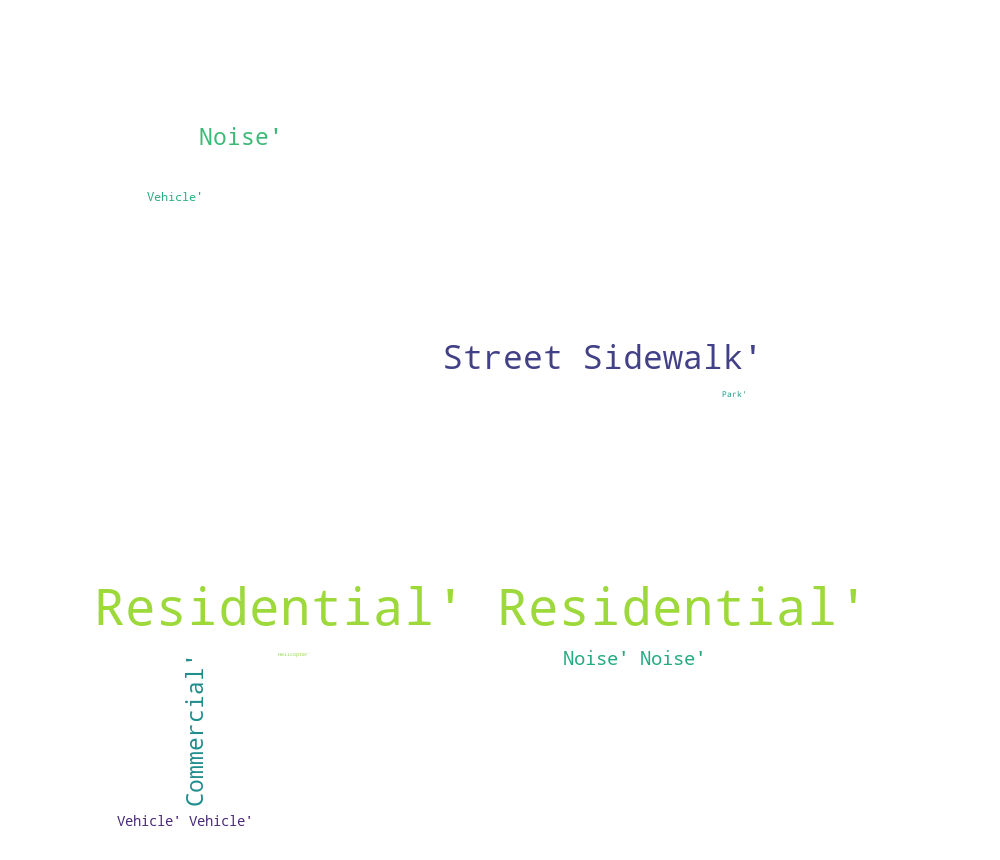

In [23]:
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(staten_island)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()
wordcloud.to_file('staten_island.png')
Image('staten_island.png')

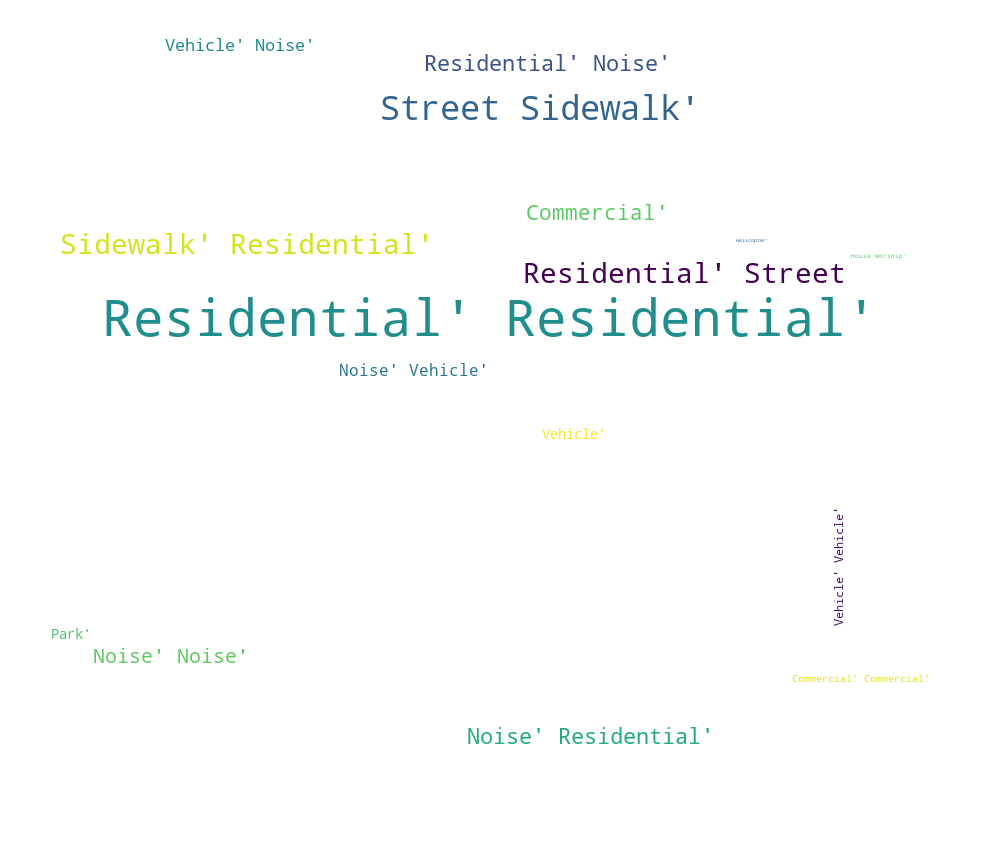

In [24]:
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(queens)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()
wordcloud.to_file('queens.png')
Image('queens.png')

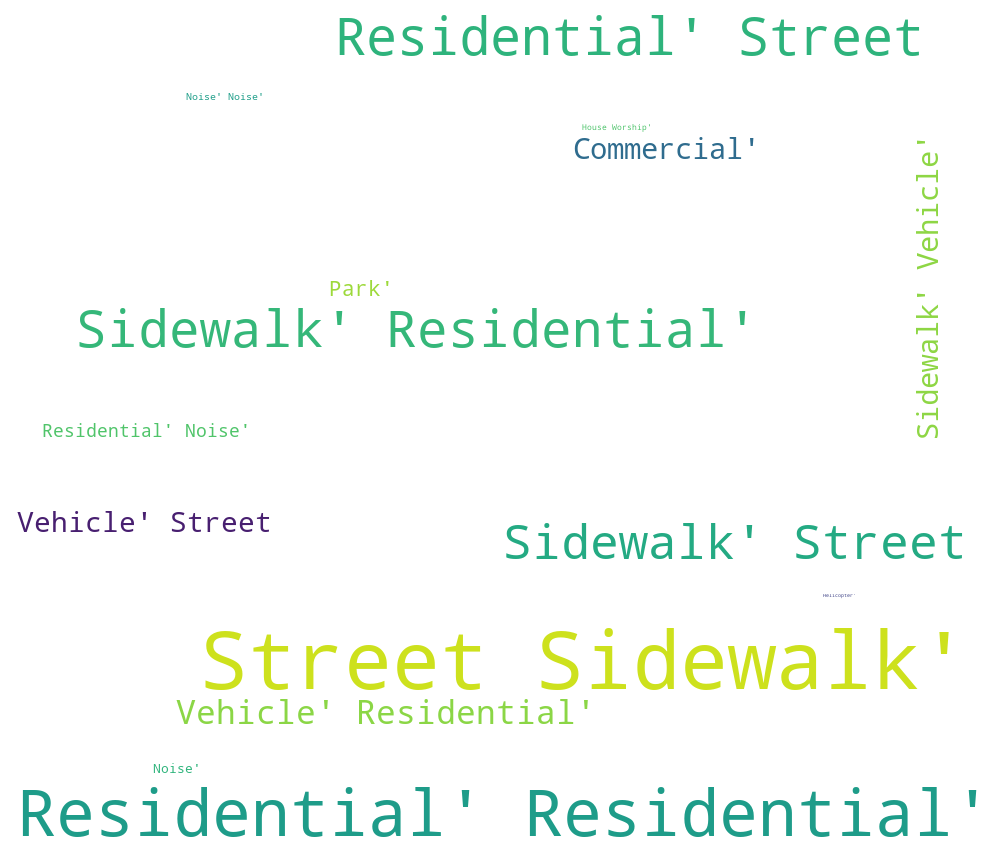

In [25]:
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(bronx)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()
wordcloud.to_file('bronx.png')
Image('bronx.png')

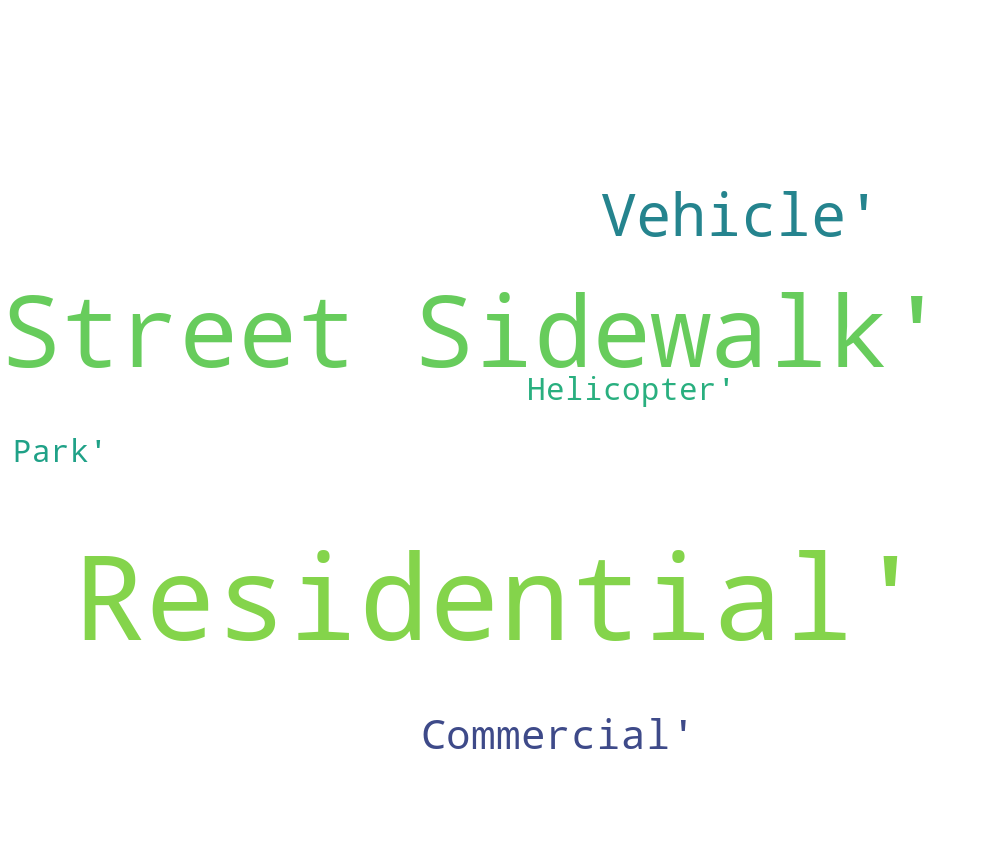

In [26]:
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(unspecified)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()
wordcloud.to_file('unspecified.png')
Image('unspecified.png')

## Visualization

In [35]:
noise311['longitude'] = noise311['longitude'].astype(float)
noise311['latitude'] = noise311['latitude'].astype(float)

In [36]:
noise311['lonlat'] = list(zip(noise311.longitude, noise311.latitude))
noise311['geometry'] = noise311[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))

In [37]:
noise311 = gpd.GeoDataFrame(noise311)

In [44]:
noise311.crs = from_epsg(4326)
# noise311.to_crs(epsg=2263)

In [40]:
noise311['noise_type'].unique()

array(['Street Sidewalk', 'Residential', 'Commercial', 'Vehicle', 'Noise',
       'Park', 'Helicopter', 'House of Worship', 'Collection Truck'],
      dtype=object)

In [41]:
bk = noise311[noise311.borough == 'BROOKLYN']

In [43]:
bk.head()

address_type agency                      agency_name         bbl   borough  \
1       ADDRESS   NYPD  New York City Police Department  3014860043  BROOKLYN   
2  INTERSECTION   NYPD  New York City Police Department         NaN  BROOKLYN   
3       ADDRESS   NYPD  New York City Police Department  3039160113  BROOKLYN   
5       ADDRESS   NYPD  New York City Police Department  3018250042  BROOKLYN   
8       ADDRESS   NYPD  New York City Police Department  3016210052  BROOKLYN   

  bridge_highway_direction bridge_highway_name bridge_highway_segment  \
1                      NaN                 NaN                    NaN   
2                      NaN                 NaN                    NaN   
3                      NaN                 NaN                    NaN   
5                      NaN                 NaN                    NaN   
8                      NaN                 NaN                    NaN   

       city              closed_date community_board           complaint_type  \
1  BROOKLYN  2018-07-01T08:03:37.000     03 BROOKLYN  Noise - Street/Sidewalk   
2  BROOKLYN  2018-07-01T02:38:03.000     05 BROOKLYN  Noise - Street/Sidewalk   
3  BROOKLYN  2018-07-01T02:01:06.000     05 BROOKLYN      Noise - Residential   
5  BROOKLYN  2018-07-01T03:37:22.000     03 BROOKLYN      Noise - Residential   
8  BROOKLYN  2018-07-01T08:03:37.000     03 BROOKLYN      Noise - Residential   

              created_date     cross_street_1       cross_street_2  \
1  2018-07-01T00:00:32.000      HOWARD AVENUE      SARATOGA AVENUE   
2  2018-07-01T00:01:01.000                NaN                  NaN   
3  2018-07-01T00:01:07.000        ETNA STREET     RIDGEWOOD AVENUE   
5  2018-07-01T00:01:08.000    TOMPKINS AVENUE        THROOP AVENUE   
8  2018-07-01T00:01:38.000  STUYVESANT AVENUE  MALCOLM X BOULEVARD   

         descriptor                 due_date facility_type  \
1      Loud Talking  2018-07-01T08:00:32.000      Precinct   
2  Loud Music/Party  2018-07-01T08:01:01.000      Precinct   
3  Loud Music/Party  2018-07-01T08:01:07.000      Precinct   
5  Loud Music/Party  2018-07-01T08:01:08.000      Precinct   
8  Loud Music/Party  2018-07-01T08:01:38.000      Precinct   

       incident_address incident_zip intersection_street_1  \
1  997 JEFFERSON AVENUE        11221                   NaN   
2                   NaN        11207         JEROME STREET   
3     50 NORWOOD AVENUE        11208                   NaN   
5     493 PUTNAM AVENUE        11221                   NaN   
8  753 LEXINGTON AVENUE        11221                   NaN   

  intersection_street_2 landmark   latitude  \
1                   NaN      NaN  40.686862   
2       GLENMORE AVENUE      NaN  40.674516   
3                   NaN      NaN  40.684846   
5                   NaN      NaN  40.684984   
8                   NaN      NaN  40.689979   

                                            location  \
1  {'type': 'Point', 'coordinates': [-73.91898258...   
2  {'type': 'Point', 'coordinates': [-73.88705300...   
3  {'type': 'Point', 'coordinates': [-73.87992879...   
5  {'type': 'Point', 'coordinates': [-73.94183381...   
8  {'type': 'Point', 'coordinates': [-73.93099729...   

                location_type  longitude open_data_channel_type park_borough  \
1             Street/Sidewalk -73.918983                 MOBILE     BROOKLYN   
2             Street/Sidewalk -73.887053                  PHONE     BROOKLYN   
3  Residential Building/House -73.879929                 MOBILE     BROOKLYN   
5  Residential Building/House -73.941834                 MOBILE     BROOKLYN   
8  Residential Building/House -73.930997                 ONLINE     BROOKLYN   

  park_facility_name resolution_action_updated_date  \
1        Unspecified        2018-07-01T08:03:37.000   
2        Unspecified        2018-07-01T02:38:03.000   
3        Unspecified        2018-07-01T02:01:06.000   
5        Unspecified        2018-07-01T03:37:22.000   
8        Unspecified        2018-07-01T08:03:37

In [77]:
truck = bk[bk['noise_type'] == "Collection Truck"]

In [69]:
commercial = bk[bk['noise_type'] == "Commercial"]

In [70]:
heli = bk[bk['noise_type'] == "Helicopter"]

In [71]:
worship = bk[bk['noise_type'] == "House of Worship"]

In [72]:
noi = bk[bk['noise_type'] == "Noise"]

In [73]:
park = bk[bk['noise_type'] == "Park"]

In [74]:
res = bk[bk['noise_type'] == "Residential"]

In [75]:
sidewalk = bk[bk['noise_type'] == "Street Sidewalk"]

In [76]:
vehicle = bk[bk['noise_type'] == "Vehicle"]

In [97]:
noise_list = [truck, commercial, heli, worship, noi, park, res, sidewalk, vehicle]

In [46]:
bkmap = gpd.GeoDataFrame.from_file("data/noise_data/BK shapefile/brooklyn_shapefile.shp")

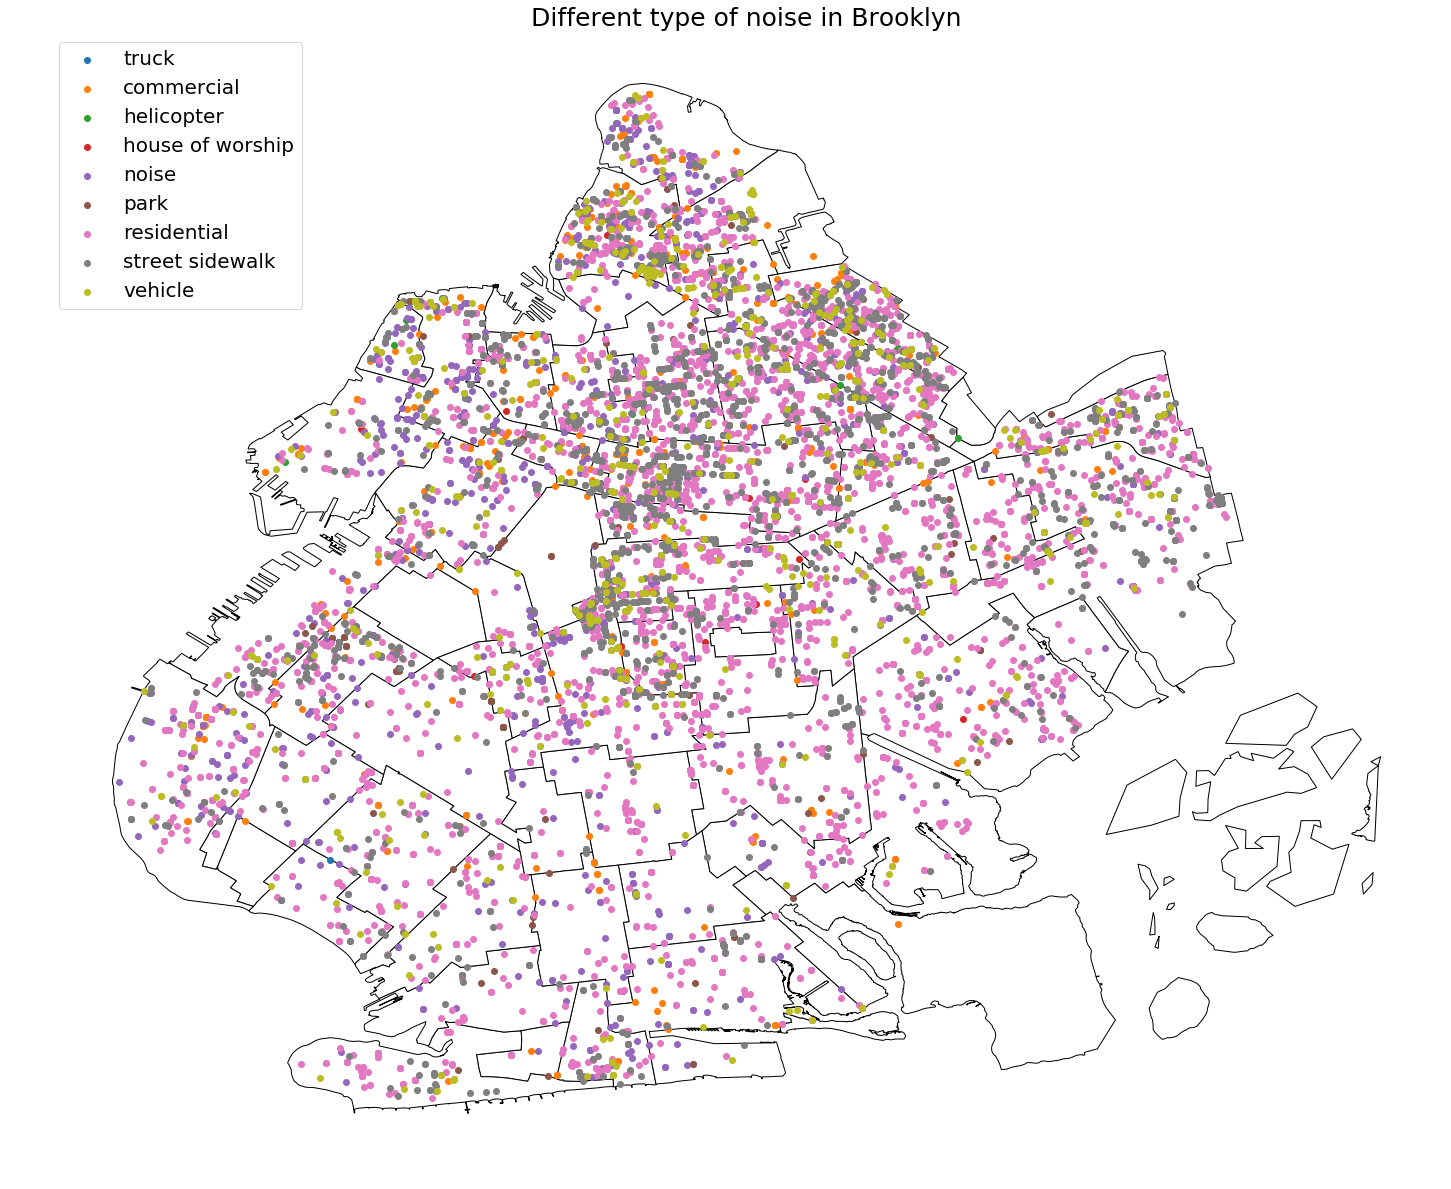

In [85]:
fig = pl.figure(figsize=(25,26)) 
ax = fig.add_subplot(111)
bkmap.plot(facecolor="w", edgecolor="k",ax=ax)
truck.plot(ax=ax, label="truck")
commercial.plot(ax=ax, label="commercial")
heli.plot(ax=ax, label="helicopter")
worship.plot(ax=ax, label="house of worship")
noi.plot(ax=ax, label="noise")
park.plot(ax=ax, label="park")
res.plot(ax=ax, label="residential")
sidewalk.plot(ax=ax, label="street sidewalk")
vehicle.plot(ax=ax, label="vehicle")
ax.set_title("Different type of noise in Brooklyn", fontsize=25)
ax.axis('off')
plt.legend(fontsize=20, loc="upper left")

In [100]:
import matplotlib.gridspec as gridspec

In [113]:
frames = {}
frames['truck'] = truck
frames['commercial'] = commercial
frames['heli'] = heli
frames['worship'] = worship
frames['noi'] = noi
frames['park'] = park
frames['res'] = res
frames['sidewalk'] = sidewalk
frames['vehicle'] = vehicle

In [162]:
log(len(frames['truck']))

0.0

In [ ]:
(x-min)/(max-min)

In [146]:
color_list = ["red","orange","blue","green","grey","purple","magenta","cyan","pink"]

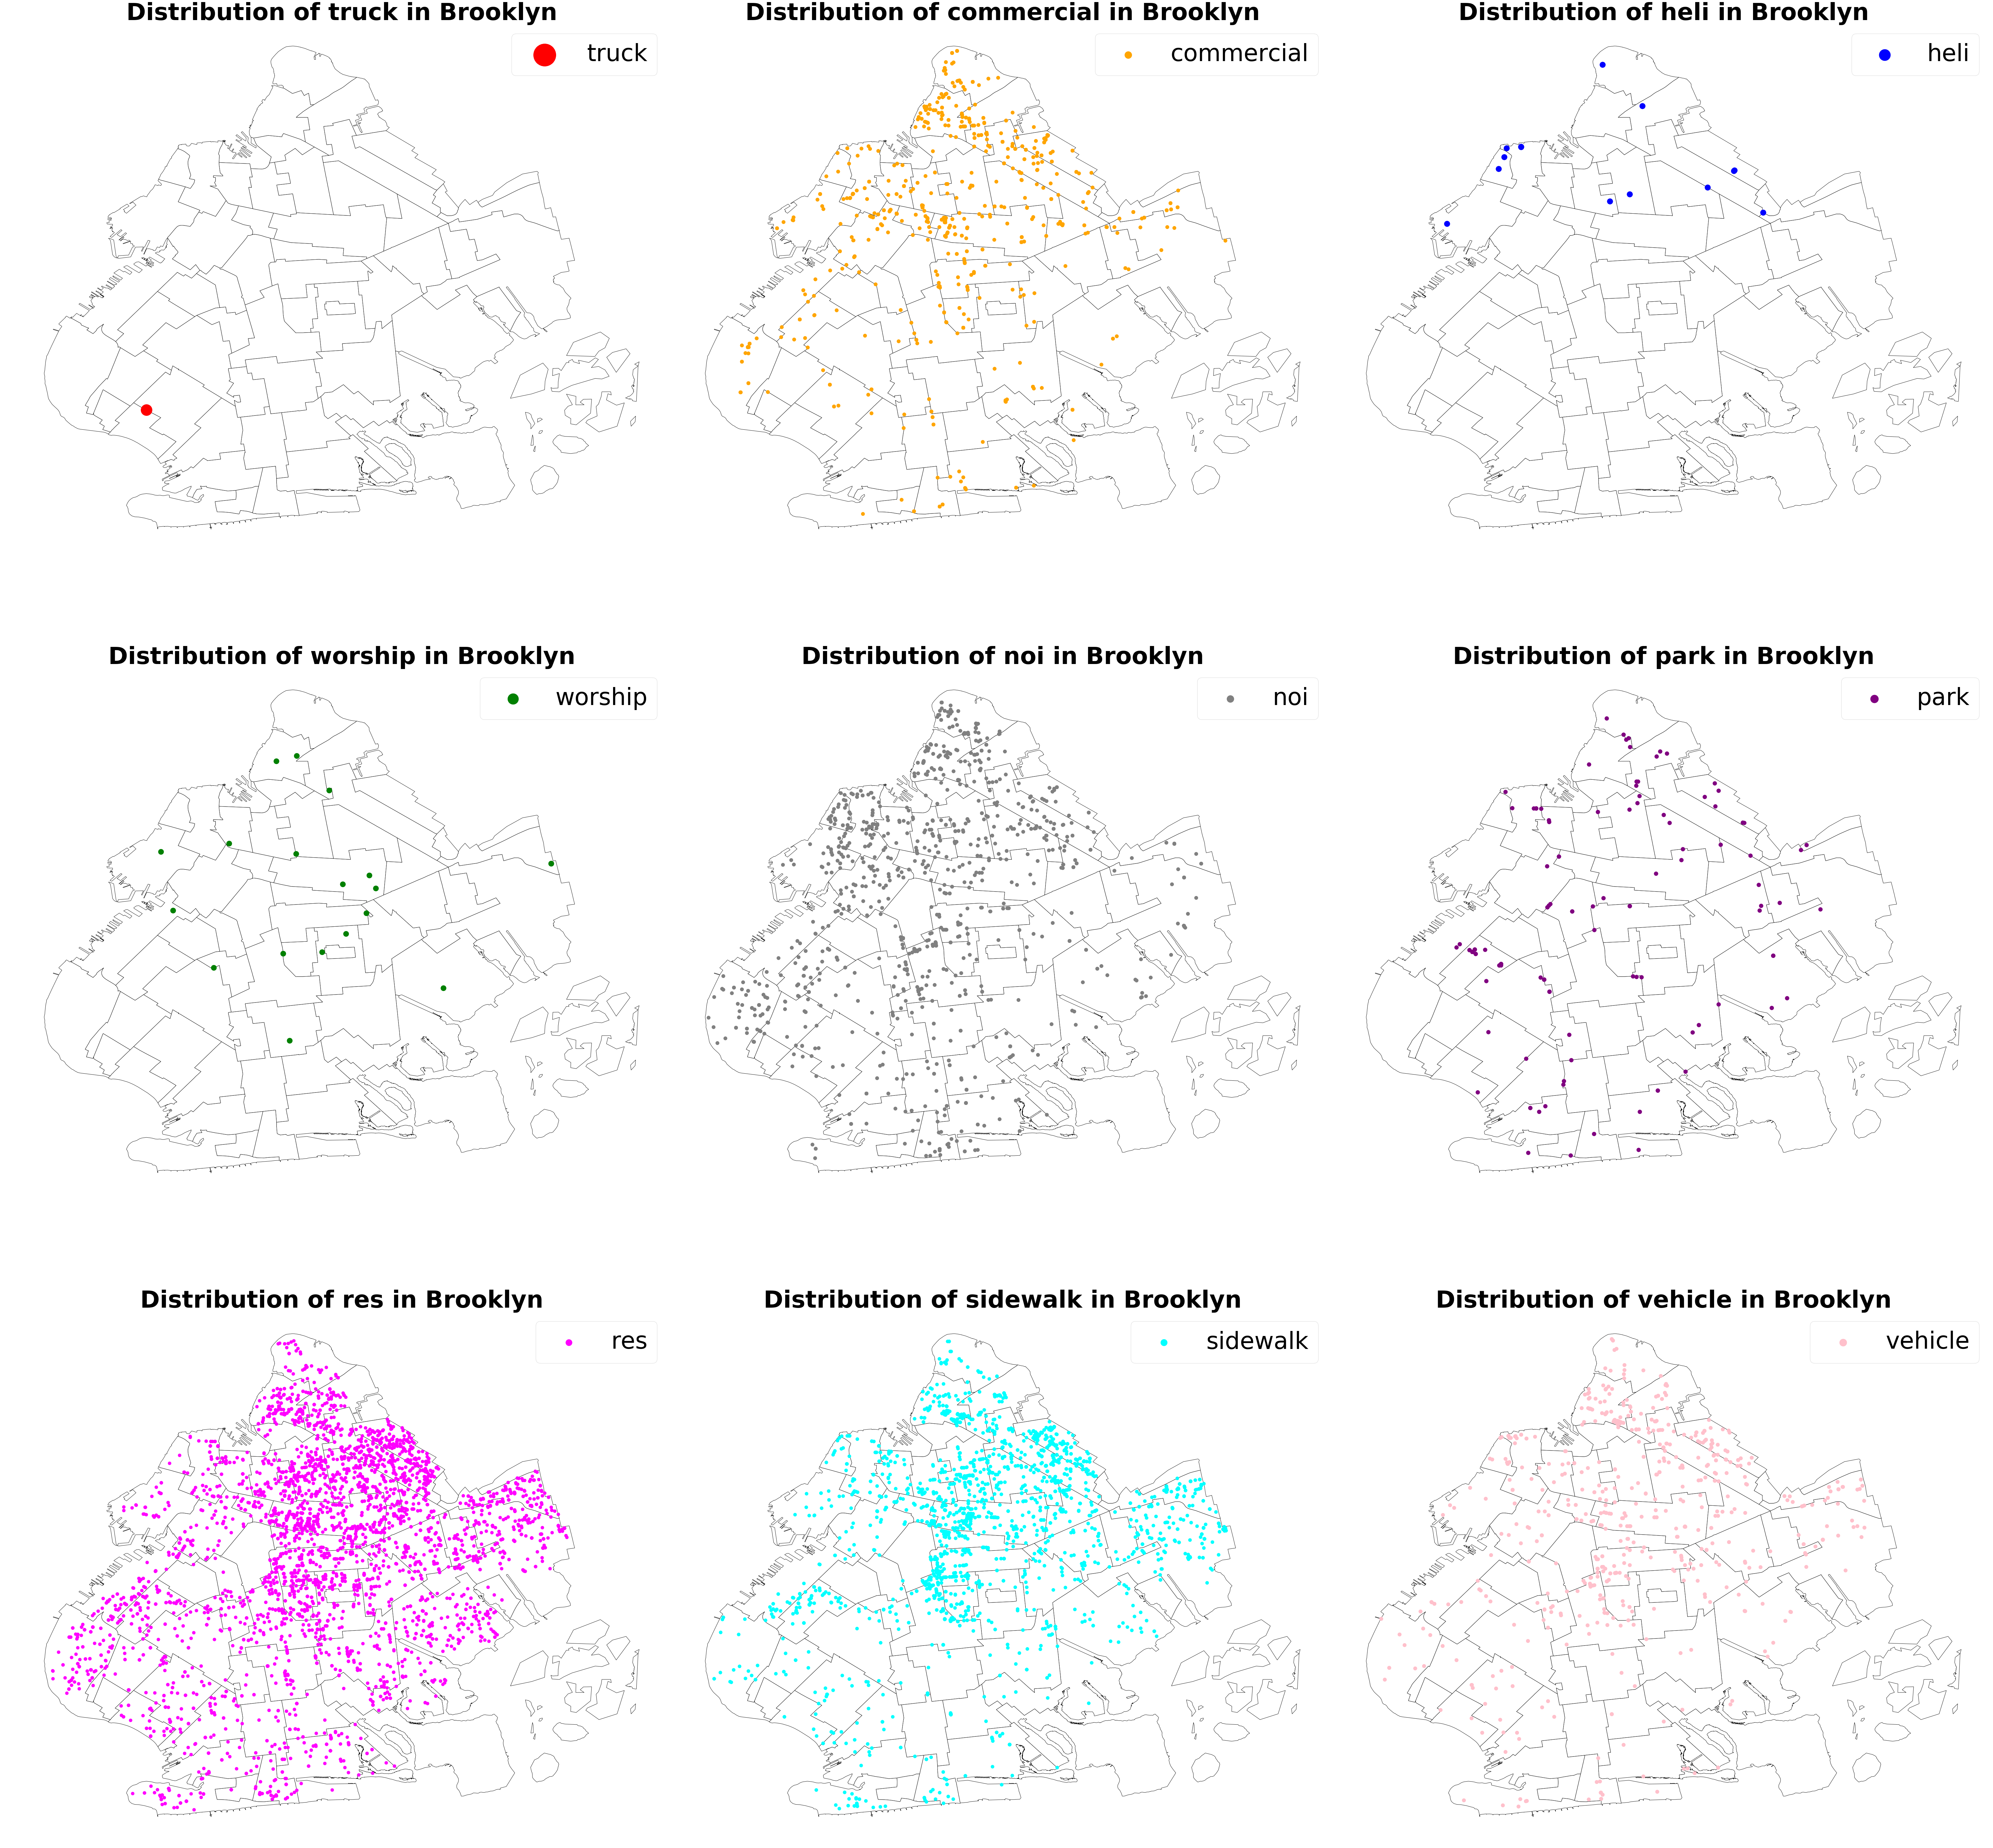

In [166]:
fig = plt.figure(figsize=(120,120))
gs = gridspec.GridSpec(3, 3)
gs.update(wspace=0.01, hspace=0.01)
i = 0
for key, frame in frames.items():
#     txt='excess kurtosis of {}: {},\n skewness of {}: {}'.format(col,kurtosis(data[col],nan_policy = 'omit'),col,skew(data[col],nan_policy = 'omit'))
    ax = plt.subplot(gs[i])
    bkmap.plot(facecolor="w", edgecolor="k",ax=ax)
    frame.plot(ax=ax, label=key ,color=color_list[i], markersize = 1000/log(len(frame)+1))
    
    ax.legend(loc='upper right', fontsize = 80 , markerscale = 2)
    ax.set_title('Distribution of {} in Brooklyn'.format(key), fontsize = 80, fontweight = 'black')
    ax.axis("off")
    i += 1
#     ax.text(0.05,-0.2, txt, size=80, ha="left", transform=ax.transAxes)
#     ax.text(0.05, 0.01, txt, ha='left',fontsize = 32)
plt.tight_layout()
#     plt.show()

For red hook community, most common type of noise complaint are: commercial, helicopter, house of worship, noise, residential, street sidewalk and vehicle.